# Demonstrating TCP Congestion Control
 
 ## Summary
 
Congestion happens in TCP when computers connected to a single link put more network packets onto the link than the link can support. Because TCP has a 100% transmission guarantee, if a sender detects lost packets, it will resend them. This will make the problem of congestion even worse.

In this Jupyter Notebook, I provide an easy way of writing and testing out different approaches to [congestion control](https://en.wikipedia.org/wiki/TCP_congestion_control), and provide an implementation of one of the original TCP congestion control approaches.

This uses [mahimahi](http://mahimahi.mit.edu/), a tool that allows network protocol developers to test different network conditions on a single machine. It comes with a bunch of options to spin up lightweight network containers that have links with different qualities. For instance, if you want to to test a link with a particular network delay, bandwidth, or queue size, you can do that quite easily.

The logic behind the setup here was inspired by work done in developing [indigo](https://github.com/StanfordSNR/indigo/tree/master/env), a reinforcement learning-based congestion control algorithm.
 
## Installation

All of the code for this project is at this [repo](https://github.com/squidarth/demonstrating-congestion-control). 
 
I've only tested this on Ubuntu--if you are using MacOS or another operating system, I highly suggest using [Vagrant](https://www.vagrantup.com) to spin up a VM.
 
 ```bash
$ sudo apt-get update
$ sudo apt-get install mahimahi python-pip -y
$ sudo apt-get install python3-pip
$ pip3 install -r requirements.txt

$ # This needs to run every time you restart the computer
$ sudo sysctl -w net.ipv4.ip_forward=1
 ```
 
 ## Usage
 
Scroll down to the bottom of the notebook to see full examples, but here's a quick start:

```python

mahimahi_settings = {
    'delay': 100,
    'queue_size': 1,
    'trace_file': TRACE_FILES['114.68MBPS']
}

run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, TahoeStrategy(10, 1))])
```

The `run_with_mahi_settings` function takes some settings, notably a `delay`, `queue_size`, and `trace_file`, along with a number of seconds that it should run for and a congestion control strategy, and then prints out some statistics on what happened. What this does is create a single sender/receiver pair that send UDP packets to one another over the mahimahi boundary.

This UDP connection, while not actually TCP, is a decent way of simulating how TCP would perform over those
network conditions, with the selected strategy.

### Writing a congestion control strategy

All congestion control strategies must inherit from `SenderStrategy`, and implement the methods `next_packet_to_send` and `process_ack`. See the `FixedWindowStrategy` in `src/strategies.py` for the simplest example of this. The `TahoeStrategy` later on in this notebook might be a better guide.

 
 ## More Details
 
 ### Trace Files
 
 The trace files were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env)
 
 This repository comes with a number of trace files in the `traces/` folder. These were taken from [this repo](https://github.com/StanfordSNR/indigo/tree/master/env). Each of these is a list of timestamps
 at which the link can send a 1500 byte packet, and it is used to set the bandwidth of the network. For a 12mbps
 (1500 bytes), it would contain numbers matching:
 
 ```
 1
 2
 3
 4
 ...
 ```

In [1]:
import socket
import select
import json
import time
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from dcc.helpers import run_with_mahi_settings, get_open_udp_port
from dcc.senders import Sender
from dcc.strategies import SenderStrategy, FixedWindowStrategy
from dcc.bayesopt import BayesOptStrategy


In [2]:
TRACE_FILES = {
    '0.57MBPS': '0.57mbps-poisson.trace',
    '2.64MBPS': '2.64mbps-poisson.trace',
    '3.04MBPS': '3.04mbps-poisson.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

## With No Congestion Control

The `FixedWindowStrategy` does not do any congestion control, and very simply sends a fixed number of packets on every round trip. The way this works is that the sender will send packets out until it has sent some number N out. It cannot send out any more until acknowledgements start coming back.

This fixed number of packets is called the "window", and we'll revisit it in later iterations of congestion control.

The larger the window, the higher the rate of packet sending.

mm-delay 88  mm-link traces/2.64mbps-poisson.trace traces/2.64mbps-poisson.trace --downlink-queue=droptail --downlink-queue-args=bytes=26400 -- sh -c 'python3 run_receiver.py $MAHIMAHI_BASE 52872'
[sender] Connected to receiver: 100.64.0.20:45175

cwnd =  2
cwnd =  3
cwnd =  4
cwnd =  5
cwnd =  6
cwnd =  7
cwnd =  8
cwnd =  9
cwnd =  10
cwnd =  11
cwnd =  12
cwnd =  13
cwnd =  14
cwnd =  15
cwnd =  16
cwnd =  17
cwnd =  18
cwnd =  19
cwnd =  20
cwnd =  21
cwnd =  22
cwnd =  23
cwnd =  24
cwnd =  25
cwnd =  26
cwnd =  27
cwnd =  28
cwnd =  29
cwnd =  30
cwnd =  31
cwnd =  32
cwnd =  33
cwnd =  34
cwnd =  35
cwnd =  36
cwnd =  37
cwnd =  38
cwnd =  39
cwnd =  40
cwnd =  41
cwnd =  42
cwnd =  43
cwnd =  44
cwnd =  45
cwnd =  46
cwnd =  47
cwnd =  48
cwnd =  49
cwnd =  50
cwnd =  51
cwnd =  52
cwnd =  53
cwnd =  54
cwnd =  55
cwnd =  56
cwnd =  57
cwnd =  58
cwnd =  59
cwnd =  60
cwnd =  61
cwnd =  62
cwnd =  63
cwnd =  64
cwnd =  65
cwnd =  66
cwnd =  67
cwnd =  68
cwnd =  69
cwnd =  70
c

cwnd =  729
cwnd =  730
cwnd =  731
cwnd =  732
cwnd =  733
cwnd =  734
cwnd =  735
cwnd =  736
cwnd =  737
cwnd =  738
cwnd =  739
cwnd =  740
cwnd =  741
cwnd =  742
cwnd =  743
cwnd =  744
cwnd =  745
cwnd =  746
cwnd =  747
cwnd =  748
cwnd =  749
cwnd =  750
cwnd =  751
cwnd =  752
cwnd =  753
cwnd =  754
cwnd =  755
cwnd =  756
cwnd =  757
cwnd =  758
cwnd =  759
cwnd =  760
cwnd =  761
cwnd =  762
cwnd =  763
cwnd =  764
cwnd =  765
cwnd =  766
cwnd =  767
cwnd =  768
cwnd =  769
cwnd =  770
cwnd =  771
cwnd =  772
cwnd =  773
cwnd =  774
cwnd =  775
cwnd =  776
cwnd =  777
cwnd =  778
cwnd =  779
cwnd =  780
cwnd =  781
cwnd =  782
cwnd =  783
cwnd =  784
cwnd =  785
cwnd =  786
cwnd =  787
cwnd =  788
cwnd =  789
cwnd =  790
cwnd =  791
cwnd =  792
cwnd =  793
cwnd =  794
cwnd =  795
cwnd =  796
cwnd =  797
cwnd =  798
cwnd =  799
cwnd =  800
cwnd =  801
cwnd =  802
cwnd =  803
cwnd =  804
cwnd =  805
cwnd =  806
cwnd =  807
cwnd =  808
cwnd =  809
cwnd =  810
cwnd =  811
cwnd

cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  18
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  19
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  20
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  21
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  22
cwnd =  23
cwnd =  23
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  24
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25
cwnd =  25

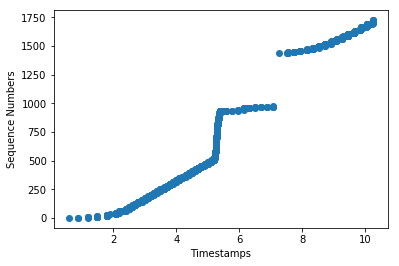

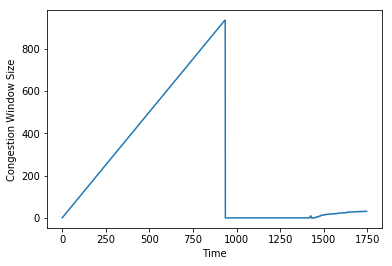

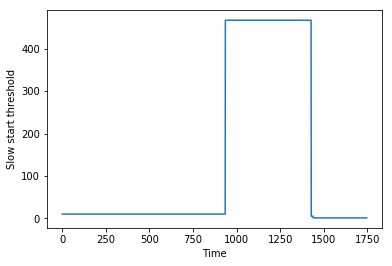

In [3]:
mahimahi_settings = {
    'delay': 88,
    'queue_size': 26400,
    'trace_file': TRACE_FILES['2.64MBPS']
}

port = get_open_udp_port()
bayes_sender = run_with_mahi_settings(mahimahi_settings, 10, [Sender(port, BayesOptStrategy(10, 1))])


In [4]:
cwnds = bayes_sender.strategy.cwnds
rtts = bayes_sender.strategy.rtts

In [5]:
cwnds[-100:]

[29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32]

In [6]:
bayes_sender.strategy

In [7]:
bayes_sender.strategy.unacknowledged_packets

{1726: {'send_ts': 1583005944.4892867, 'seq_num': 1726},
 1727: {'send_ts': 1583005944.4895203, 'seq_num': 1727},
 1728: {'send_ts': 1583005944.4897685, 'seq_num': 1728},
 1729: {'send_ts': 1583005944.4899693, 'seq_num': 1729},
 1730: {'send_ts': 1583005944.4901934, 'seq_num': 1730},
 1731: {'send_ts': 1583005944.4922857, 'seq_num': 1731},
 1732: {'send_ts': 1583005944.492627, 'seq_num': 1732},
 1733: {'send_ts': 1583005944.4928932, 'seq_num': 1733},
 1734: {'send_ts': 1583005944.51702, 'seq_num': 1734},
 1735: {'send_ts': 1583005944.517261, 'seq_num': 1735},
 1736: {'send_ts': 1583005944.5175145, 'seq_num': 1736},
 1737: {'send_ts': 1583005944.5178385, 'seq_num': 1737},
 1738: {'send_ts': 1583005944.5180495, 'seq_num': 1738},
 1739: {'send_ts': 1583005944.5182736, 'seq_num': 1739},
 1740: {'send_ts': 1583005944.5184956, 'seq_num': 1740},
 1741: {'send_ts': 1583005944.518716, 'seq_num': 1741},
 1742: {'send_ts': 1583005944.518913, 'seq_num': 1742},
 1743: {'send_ts': 1583005944.519132,

In [8]:
len(bayes_sender.strategy.cwnds)

1748

In [9]:
len(bayes_sender.strategy.rtts)

1242